In [1]:
#@title Mount Google Drive (Need google account authorization)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Download the source code

GIT_REPO = 'https://github.com/kaistsystemsbiology/DeepProZyme.git'

# !rm -rf deepzyme
!git clone -b main --single-branch {GIT_REPO}

Cloning into 'DeepZyme'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1057 (delta 88), reused 157 (delta 86), pack-reused 896
Receiving objects: 100% (1057/1057), 79.79 MiB | 37.93 MiB/s, done.
Resolving deltas: 100% (650/650), done.


In [6]:
%%capture
#@title Install dependencies (It takes 1~3 mins)

!pip install transformers==3.5.1
!pip install torch==1.7.0
!pip install logomaker

!pip install -q condacolab
import condacolab
condacolab.install()

# !conda install -c conda-forge biopython=1.78
# !pip install transformers
!conda install -c bioconda diamond=2.0.15

In [15]:
#@title Import modules
%cd ./DeepZyme/

import os
import shutil
import logging

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import logomaker

from deepec.data_loader import DeepECDataset
from deepec.utils import argument_parser, run_neural_net, save_dl_result
from deepec.homology import run_blastp, read_best_blast_result, merge_predictions



def get_attention_map(model, input_ids, token_type_ids, attention_mask, output_attentions=False):
    _, _, attentions = model.bert(input_ids, token_type_ids, attention_mask, )
    return attentions


def _draw_logo_map(input_seq, attn, columns_aas, layer, head, output_dir, dir='row'):
    if dir=='row':
        dim=0
    elif dir=='column':
        dim=1
    else:
        raise Exception('Wrong direction')
    df_array = np.zeros((len(input_seq), 20))
    for j, aa in enumerate(input_seq):
        aa_ind = columns_aas.index(aa)
        df_array[j][aa_ind] = attn.mean(dim=dim)[j]
    df = pd.DataFrame(df_array)
    df.columns = columns_aas
    df.index = df.index + 1
    nn_logo = logomaker.Logo(df, color_scheme='chemistry', figsize=(20, 2.5), )
    plt.savefig(f'{output_dir}/logo_{layer}_{head}_{dir}.png', dpi=300)
    plt.close()


def _get_highlighted(df_array, input_seq, thrd=0.5):
    max_value = df_array.max()
    residues = []
    for ix in (df_array.sum(axis=1)>thrd*max_value).nonzero()[0]:
        residues.append(f'{ix+1}{input_seq[ix]}')
    return residues
    
def draw_logo_map(input_seq, attention, layer, head_num, output_dir):
    columns_aas = [
        'A', 'C', 'D', 'E', 
        'F', 'G', 'H', 'I', 
        'K', 'L', 'M', 'N', 
        'P', 'Q', 'R', 'S',
        'T', 'V', 'W', 'Y'
    ]
    highlighted_residues = {}
    fig, axes = plt.subplots(8, sharex=True, figsize=(20, 2.5*head_num))
    
    for head in range(head_num):
        attn = attention[head][1:len(input_seq)+1, 1:len(input_seq)+1].detach()
        
        df_array = np.zeros((len(input_seq), 20))
        for j, aa in enumerate(input_seq):
            aa_ind = columns_aas.index(aa)
            df_array[j][aa_ind] = attn.mean(dim=0)[j]
#             df_array[j][aa_ind] = attn.max(dim=0)[0][j]
        df = pd.DataFrame(df_array)
        df.columns = columns_aas
        df.index = df.index + 1
        nn_logo = logomaker.Logo(df, color_scheme='chemistry', figsize=(20, 2.5), ax=axes[head])

        highlighted_residues[head] = _get_highlighted(df_array, input_seq, thrd=0.5)
        
    plt.savefig(f'{output_dir}/logo_{layer}.png', dpi=300)
    plt.show()
    plt.close()
    
    with open(f'{output_dir}/highlighted_residues_{layer}.txt', 'w') as fp:
        fp.write('Head\tResidues\n')
        for head, residues in highlighted_residues.items():
            residues.sort()
            residues = ';'.join(residues)
            fp.write(f'{head}\t{residues}\n')

In [16]:
#@title Set the basic configuration

device = 'cpu'
num_cpu = 1
batch_size = 128
output_dir = './deepec_results'
checkpt_file = './model/model.pth'
attn_dir = './attn'

torch.set_num_threads(num_cpu)

model = torch.load(checkpt_file)
model = model.to(device)
model.bert.config.output_attentions = False
model.eval()
explainECs = model.explainECs
pred_thrd = pred_thrd = model.thresholds.to(device)
ec2ind = {ec: i for i, ec in enumerate(explainECs)}

In [17]:
#@title Input (protein sequence)
from google.colab import files 
import os.path 
import re
import hashlib
import random 

def add_hash(x,y):
    return x + '_' + hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MAEQVALSRT QVCGILREEL FQGDAFHQSD THIFIIMGAS GDLAKKKIYP TIWWLFRDGL LPENTFIVGY ARSRLTVADI RKQSEPFFKA TPEEKLKLED FFARNSYVAG QYDDAASYQR LNSHMNALHL GSQANRLFYL ALPPTVYEAV TKNIHESCMS QIGWNRIIVE KPFGRDLQSS DRLSNHISSL FREDQIYRID HYLGKEMVQN LMVLRFANRI FGPIWNRDNI ACVILTFKEP FGTEGRGGYF DEFGIIRDVM QNHLLQMLCL VAMEKPASTN SDDVRDEKVK VLKCISEVQA NNVVLGQYVG NPDGEGEATK GYLDDPTVPR GSTTATFAAV VLYVENERWD GVPFILRCGK ALNERKAEVR LQFHDVAGDI FHQQCKRNEL VIRVQPNEAV YTKMMTKKPG MFFNPEESEL DLTYGNRYKN VKLPDAYERL ILDVFCGSQM HFVRSDELRE AWRIFTPLLH QIELEKPKPI PYIYGSRGPT EADELMKRVG FQYEGTYKWV NPHKL' #@param {type:"string"}

def process_seq(seq):
    import re
    p = re.compile('\s')
    seq = p.sub('', seq)
    columns_aas = [
        'A', 'C', 'D', 'E', 
        'F', 'G', 'H', 'I', 
        'K', 'L', 'M', 'N', 
        'P', 'Q', 'R', 'S',
        'T', 'V', 'W', 'Y'
    ]
    sequences = []
    ecs = []
    ids = []

    if len(seq) >= 1000:
        seq = seq[:1000]        
    if len(set(seq) - set(columns_aas)) > 0:
        return sequences

    sequences.append(seq)

    return sequences

input_seqs = process_seq(query_sequence)

In [18]:
#@title Process input data

input_ids = ['Query_1']
id2ind = {seq_id: i for i, seq_id in enumerate(input_ids)}
pseudo_labels = np.zeros((len(input_seqs)))
proteinDataset = DeepECDataset(data_X=input_seqs, data_Y=pseudo_labels, explainECs=explainECs, pred=True)
proteinDataloader = DataLoader(proteinDataset, batch_size=batch_size, shuffle=False)

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

In [19]:
#@title Run DeepECtransformer

y_pred, y_score = run_neural_net(model, proteinDataloader, pred_thrd, device=device)
if not os.path.exists(output_dir+'/tmp'):
    os.makedirs(output_dir+'/tmp')
failed_cases = save_dl_result(y_pred, y_score, input_ids, explainECs, output_dir+'/tmp')

if len(failed_cases) > 0:
    DL_success = False
    blastp_input = f'{output_dir}/tmp/temp_seq.fa'
    blastp_tmp_output = f'{output_dir}/tmp/blast_tmp_result.txt'
    blastp_output = f'{output_dir}/tmp/blast_result.txt'

    with open(blastp_input, 'w') as fp:
        for seq_id in failed_cases:
            idx = id2ind[seq_id]
            seq = input_seqs[idx]
            fp.write(f'>{seq_id}\n{seq}\n')

    # run_blastp(blastp_input, blastp_tmp_output, './model/swissprot_enzyme_diamond', threads=num_cpu)
    ! diamond blastp -d ./model/swissprot_enzyme_diamond -q {blastp_input} -o {blastp_tmp_output} --threads 4 --id 50 --outfmt 6 qseqid sseqid evalue score qlen slen length pident
    blastp_pred = read_best_blast_result(blastp_tmp_output)
    
    with open(blastp_output, 'w') as fp:
        fp.write('sequence_ID\tprediction\n')
        for seq_id in blastp_pred:
            ec = blastp_pred[seq_id][0]
            fp.write(f'{seq_id}\t{ec}\n')

    merge_predictions(f'{output_dir}/tmp/DL_prediction_result.txt', blastp_output, output_dir)

else:
    DL_success = True
    shutil.copy(output_dir+'/tmp/DL_prediction_result.txt', output_dir)
    os.rename(output_dir+'/DL_prediction_result.txt', output_dir+'/DeepECv2_result.txt')

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
#@title Show the result

df = pd.read_csv(output_dir+'/DeepECv2_result.txt', sep='\t')
display(df)

,sequence_ID,prediction,score
0,Query_1,EC:1.1.1.49,0.9998


Layer number: 1


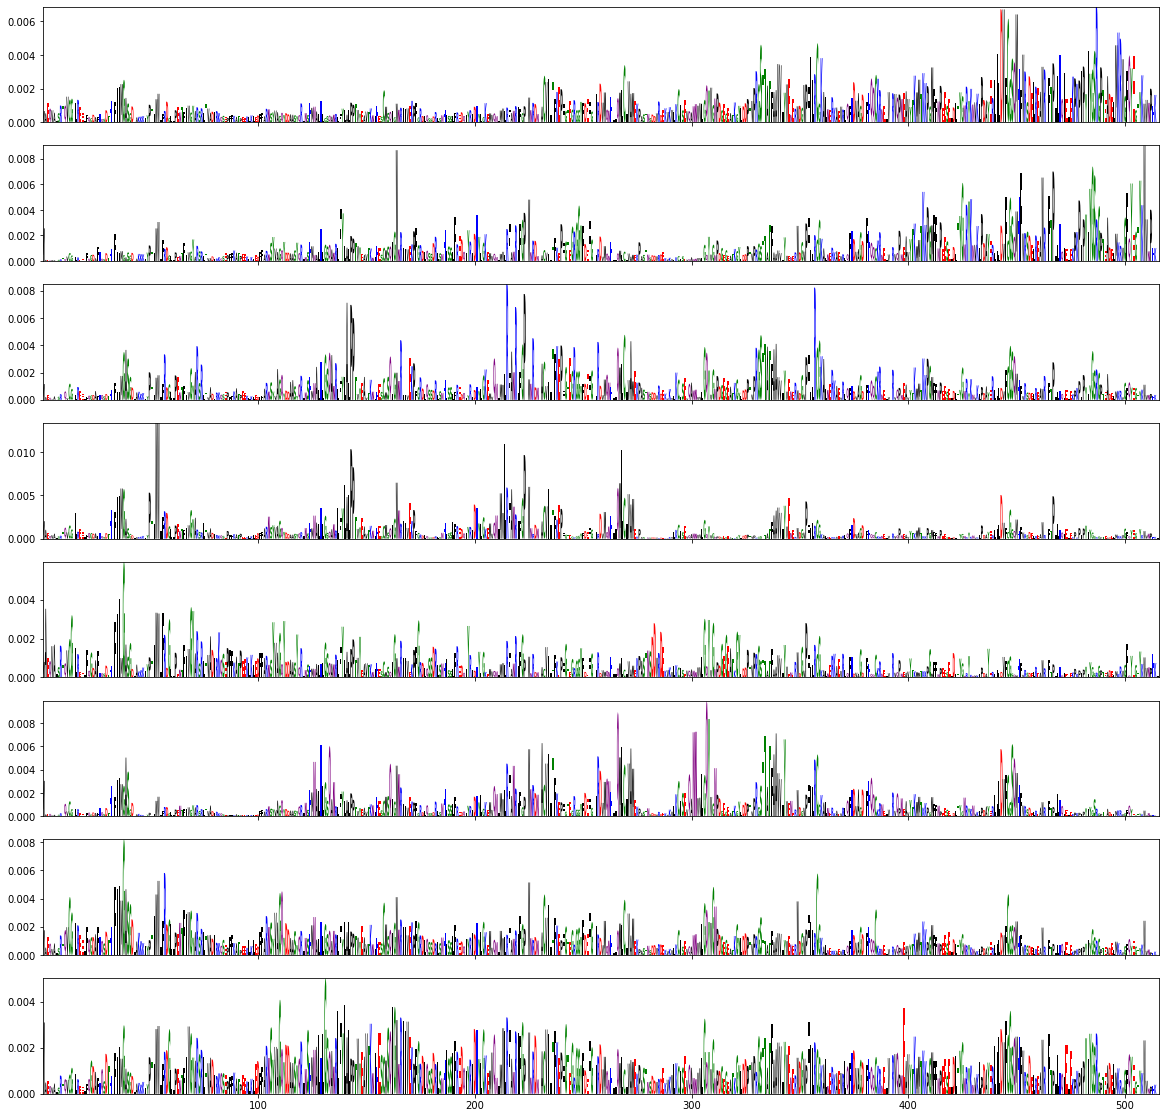

In [21]:
#@title Analyze the attention layers

if DL_success:
    model.bert.config.output_attentions = False
    model.eval()
    for item in proteinDataloader:
        break
    pred = model(**item)
    pred = torch.sigmoid(pred)

    model.bert.config.output_attentions = True
    attentions = get_attention_map(model, **item)
    model.bert.config.output_attentions = False


    %matplotlib inline

    for i, seq_id in enumerate(input_ids):
        output_dir = f'{attn_dir}/{seq_id}'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        layer_num = len(attentions)
        head_num = attentions[0].size()[1]
        seq_len = len(input_seqs[i])
            
        for layer in range(layer_num):
            if layer == 0: continue
            print(f'Layer number: {layer}')
            attention = attentions[layer][i]
            draw_logo_map(input_seqs[i], attention, layer, head_num, output_dir)
else:
    print('Neural net failed to predict')